In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import statistics as st
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap.umap_ as umap
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import kneighbors_graph
import scipy.sparse as sparse
from pylab import rcParams
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsClassifier
import scipy.io as sio
import sys
from sknetwork.clustering import Louvain, modularity, bimodularity
from sknetwork.linalg import normalize
from sknetwork.utils import bipartite2undirected, membership_matrix
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from IPython.display import SVG
print("Imported")

Imported


In [49]:
matrix_freq = sio.loadmat('matrix_freq_s8.mat')
matrix_freq = np.array(list(matrix_freq['matrix_freq_s8']))
matrix_freq_test = sio.loadmat('matrix_freq_s8_test.mat')
matrix_freq_test = np.array(list(matrix_freq_test['matrix_freq_s8_test']))
labels = np.array([0 for i in range(matrix_freq.shape[2])])
labels[:37] = 1
np.set_printoptions(threshold=sys.maxsize)
#print(matrix)
#print(labels)
#print(matrix_time.shape)
print(matrix_freq.shape)
print(matrix_freq_test.shape)

(60, 1200, 73)
(60, 1200, 18)


## designing the filter
from scipy import signal
numtaps = 51
f1, f2 = 0.5, 40
filter = signal.firwin(numtaps, f1, pass_zero=False, fs = 1000)
plt.plot(filter)
plt.show()

#filter the data
plt.plot(car[1,:,1])
plt.show()
plt.plot(face[1,:,1])
plt.show() 
for i in range(car.shape[0]):
    for j in range(car.shape[2]):
        car[i,:,j] = signal.convolve(car[i,:,j], filter, mode='same')
    for j in range(face.shape[2]):
        face[i,:,j] = signal.convolve(face[i,:,j], filter, mode='same')
plt.plot(car[1,:,1])
plt.show()
plt.plot(face[1,:,1])
plt.show()      

In [50]:
#set up the parameters
#pca = PCA(n_components=0.95)
reducer2D = umap.UMAP(n_components=2, init='random', random_state=0, n_neighbors = 15, min_dist = 0.0)
km = KMeans(n_clusters=2, random_state=0)
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [51]:
#frequency filtered
windowStart = 399
windowLength = 25
windowNum = 150
windowCurr = windowStart
predAgg = 0
performance = [0 for i in range(windowNum)]
for i in range(windowNum):
    #create combined matrix
    matrix = matrix_freq[:,windowCurr:windowCurr+windowLength,:]
    matrix = np.average(matrix, axis=1)
    numTrain = matrix.shape[1]
    matrix_test = matrix_freq_test[:,windowCurr:windowCurr+windowLength,:]
    matrix_test = np.average(matrix_test, axis=1)
    matrix = np.concatenate((matrix,matrix_test), axis=1)
    #print(matrix.shape)
    #run UMAP
    embedding2D = reducer2D.fit_transform(matrix.T)
    embedding2D.shape
    #run KMeans
    embedding_km = km.fit_predict(embedding2D)
    #find the weight cluster
    weight_cluster = np.where(embedding_km == 0, -1, embedding_km)
    eu_dist = km.transform(embedding2D)**0.5
    weight_pred = [0 for j in range(len(eu_dist))]
    weight = abs((numTrain/2)-np.count_nonzero(embedding_km[:numTrain]==labels))/10
    for j in range(len(eu_dist)):
        weight_pred[j] = weight/(min(eu_dist[j])/sum(eu_dist[j]))
    weight_cluster = weight_cluster*weight_pred
    #determine consistent cluster
    performance[i] = abs((numTrain/2)-np.count_nonzero(embedding_km[:numTrain]==labels))
    if np.count_nonzero(embedding_km[:numTrain]==labels)/len(embedding_km[:numTrain]) < 0.5:
        weight_cluster = weight_cluster*-1
    #add to the predictor
    if i == 0:
        predAgg = weight_cluster
    else:
        predAgg = predAgg + weight_cluster
    #increase the index
    windowCurr = windowCurr + 3
print(performance)

[6.5, 7.5, 7.5, 8.5, 3.5, 5.5, 0.5, 5.5, 0.5, 1.5, 0.5, 0.5, 4.5, 6.5, 5.5, 4.5, 5.5, 5.5, 6.5, 7.5, 3.5, 4.5, 2.5, 2.5, 2.5, 5.5, 2.5, 2.5, 5.5, 8.5, 11.5, 9.5, 12.5, 10.5, 5.5, 3.5, 15.5, 16.5, 0.5, 16.5, 2.5, 16.5, 11.5, 15.5, 12.5, 13.5, 9.5, 6.5, 5.5, 5.5, 6.5, 8.5, 4.5, 4.5, 0.5, 1.5, 1.5, 0.5, 1.5, 2.5, 1.5, 3.5, 1.5, 2.5, 2.5, 0.5, 0.5, 1.5, 0.5, 0.5, 2.5, 2.5, 0.5, 1.5, 0.5, 2.5, 2.5, 1.5, 2.5, 2.5, 2.5, 4.5, 4.5, 6.5, 2.5, 4.5, 1.5, 1.5, 2.5, 2.5, 2.5, 4.5, 9.5, 3.5, 8.5, 7.5, 10.5, 1.5, 9.5, 5.5, 4.5, 6.5, 3.5, 3.5, 0.5, 3.5, 3.5, 7.5, 9.5, 11.5, 14.5, 14.5, 5.5, 9.5, 10.5, 7.5, 2.5, 1.5, 2.5, 0.5, 3.5, 2.5, 3.5, 2.5, 0.5, 1.5, 0.5, 0.5, 1.5, 0.5, 3.5, 1.5, 4.5, 5.5, 6.5, 5.5, 2.5, 3.5, 5.5, 0.5, 1.5, 4.5, 1.5, 0.5, 0.5, 1.5, 2.5, 3.5, 1.5, 4.5]


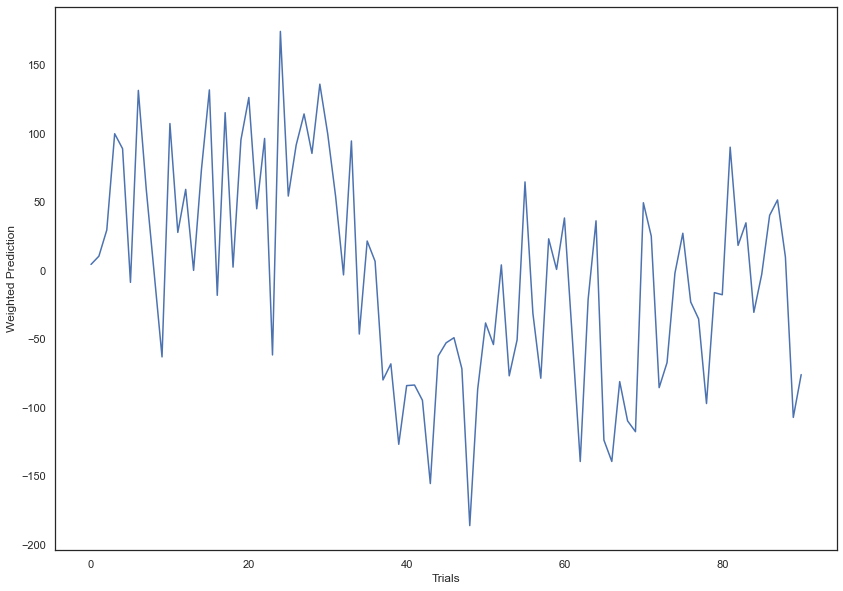

[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]


In [52]:
import kmeans1d
#predAggSorted = np.sort(predAgg)
plt.plot(predAgg)
plt.xlabel('Trials')
plt.ylabel('Weighted Prediction')
plt.show()
pred_clusters, pred_centroids = kmeans1d.cluster(predAgg,2)
#print(np.count_nonzero(pred_clusters==labels))
print(pred_clusters[numTrain:])

#time filtered
windowStart = 0
windowLength = 15
windowNum = 45
windowCurr = windowStart
#weight = 5
predAgg = 0
for i in range(windowNum):
    matrix = matrix_time[:,windowCurr:windowCurr+windowLength,:]
    matrix = np.average(matrix, axis=1)
    #run PCA
    #principalComponents = pca.fit_transform(matrix.T)
    #principalDf = pd.DataFrame(data = principalComponents)
    #run UMAP
    embedding2D = reducer2D.fit_transform(matrix.T)
    embedding2D.shape
    #run KMeans
    embedding_km = km.fit_predict(embedding2D)
    #find the weight cluster
    weight_cluster = np.where(embedding_km == 0, -1, embedding_km)
    eu_dist = km.transform(embedding2D)
    weight_pred = [0 for j in range(len(eu_dist))]
    weight = abs(250-np.count_nonzero(embedding_km==labels))/10
    for j in range(len(eu_dist)):
        weight_pred[j] = weight/(min(eu_dist[j])/sum(eu_dist[j]))
    weight_cluster = weight_cluster*weight_pred
    #determine consistent cluster
    print(abs(250-np.count_nonzero(embedding_km==labels)))
    if np.count_nonzero(embedding_km==labels)/len(embedding_km) < 0.5:
        weight_cluster = weight_cluster*-1
    #add to the predictor
    if i == 0:
        predAgg = weight_cluster
    else:
        predAgg = predAgg + weight_cluster
    #increase the index
    windowCurr = windowCurr + 1

plt.plot(predAgg)
plt.show()
pred_clusters, pred_centroids = kmeans1d.cluster(predAgg,2)
print(np.count_nonzero(pred_clusters==labels))
print(pred_clusters)